In [1]:
#import SQL library
import pyodbc
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import matplotlib.ticker as ticker
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 26

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
#establishes an open connection to SQL
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=LENOVO-PC\SQLEXPRESS;'
                      'Database=AdventureWorks2012;'
                      'Trusted_Connection=yes;')

In [3]:
#pull RESELLER data from SQL including Territory and Revenue 

pythonSQLobject=pd.read_sql_query("""
SELECT * FROM [dbo].[ONLINE_SELLER_FORECAST]""", conn)

conn.close() # please close it after !


In [4]:
dataset = pythonSQLobject

In [5]:
dataset.head()

,OrderDate,Revenue,Territory_Name
0,2011-05-31,3578.2700,Canada
1,2011-05-31,3399.9900,France
2,2011-05-31,3399.9900,Northwest
3,2011-05-31,699.0982,Southwest
4,2011-05-31,3399.9900,Australia


In [6]:
dataset.shape

(60398, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 3 columns):
OrderDate         60398 non-null datetime64[ns]
Revenue           60398 non-null float64
Territory_Name    60398 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB



## Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running

In [8]:
SE = dataset.loc[dataset['Territory_Name'] == 'Southeast']
SW = dataset.loc[dataset['Territory_Name'] == 'Southwest']
C = dataset.loc[dataset['Territory_Name'] == 'Central']
SE.shape, SW.shape, C.shape

((39, 3), (12265, 3), (20, 3))

In [9]:
SE['OrderDate'] =  pd.to_datetime(SE['OrderDate'], format='%Y/%m')
SE = SE.sort_values(by=['OrderDate'], ascending=[True])
SE.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

SW['OrderDate'] =  pd.to_datetime(SW['OrderDate'], format='%Y/%m')
SW = SW.sort_values(by=['OrderDate'], ascending=[True])
SW.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

C['OrderDate'] =  pd.to_datetime(C['OrderDate'], format='%Y/%m')
C = C.sort_values(by=['OrderDate'], ascending=[True])
C.set_index('OrderDate', inplace=True) # Indexing with Time Series Data

SE.drop(["Territory_Name"],axis=1, inplace=True)
SW.drop(["Territory_Name"],axis=1, inplace=True)
C.drop(["Territory_Name"],axis=1, inplace=True)

In [10]:
#y = df.resample('MS').mean()
y_SE = SE.resample('MS').sum()
y_SW = SW.resample('MS').sum()
z_C = C.resample('MS').sum()

In [11]:
# filling up by mean value
y_SE = y_SE['Revenue'].replace(0.000000, y_SE['Revenue'].mean())
y_SW = y_SW['Revenue'].replace(0.000000, y_SW['Revenue'].mean())
z_C = z_C['Revenue'].replace(0.000000, z_C['Revenue'].mean())

In [12]:
SE = pd.DataFrame({'OrderDate': y_SE.index, 'Revenue': y_SE.values})
SW = pd.DataFrame({'OrderDate': y_SW.index, 'Revenue': y_SW.values})
C = pd.DataFrame({'OrderDate': z_C.index, 'Revenue': z_C.values})

In [13]:
store = SE.merge(SW,how='inner', on='OrderDate')
store.rename(columns={'Revenue_x': 'SE_revenue', 'Revenue_y': 'SW_revenue'}, inplace=True)
store.head()

,OrderDate,SE_revenue,SW_revenue
0,2012-07-01,782.990000,99214.7454
1,2012-08-01,509.952067,47788.8120
2,2012-09-01,509.952067,41333.2937
3,2012-10-01,509.952067,56732.9223
4,2012-11-01,782.990000,83301.3529


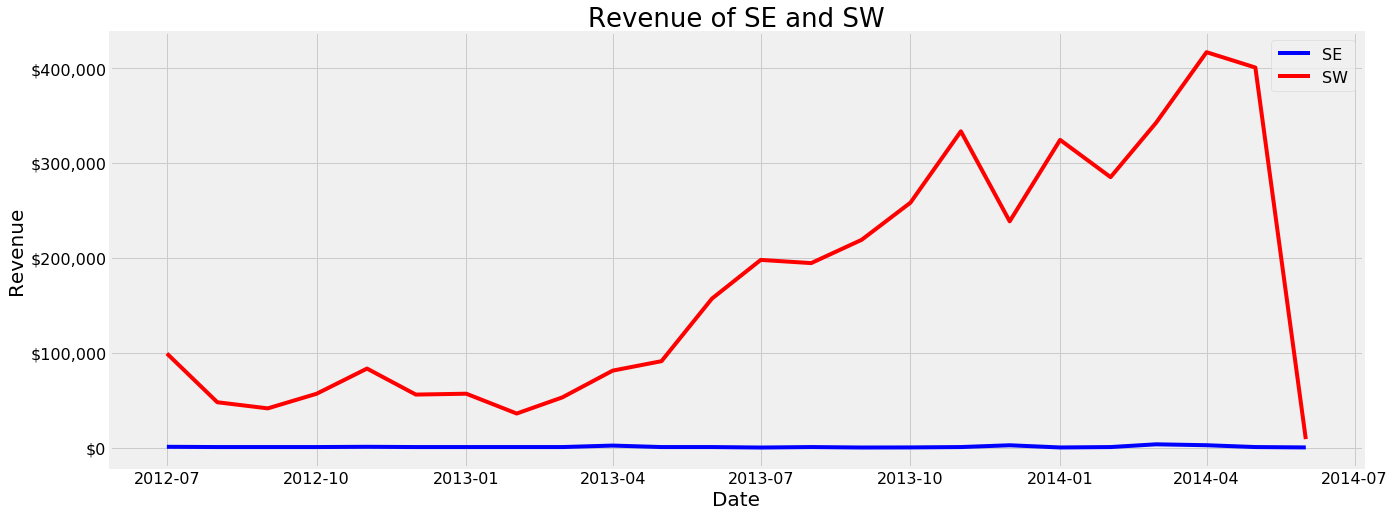

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(store['OrderDate'], store['SE_revenue'], 'b-', label = 'SE')
plt.plot(store['OrderDate'], store['SW_revenue'], 'r-', label = 'SW')
plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Revenue of SE and SW')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.legend();

# Fitt Model with Prophet

In [15]:
from fbprophet import Prophet
SE = SE.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
SE_model = Prophet(interval_width=0.95)
SE_model.fit(SE)

SW = SW.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
SW_model = Prophet(interval_width=0.95)
SW_model.fit(SW)

C = C.rename(columns={'OrderDate': 'ds', 'Revenue': 'y'})
C_model = Prophet(interval_width=0.95)
C_model.fit(C)

SE_forecast = SE_model.make_future_dataframe(periods=60, freq='MS')
SE_forecast = SE_model.predict(SE_forecast)

SW_forecast = SW_model.make_future_dataframe(periods=60, freq='MS')
SW_forecast = SW_model.predict(SW_forecast)

C_forecast = C_model.make_future_dataframe(periods=60, freq='MS')
C_forecast = C_model.predict(C_forecast)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 18.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than num

<Figure size 2016x864 with 0 Axes>

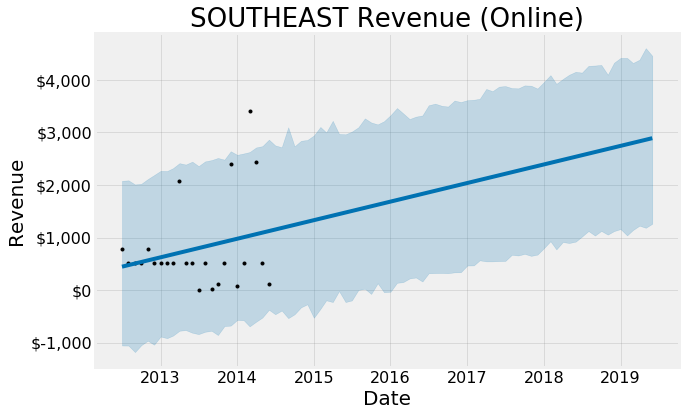

In [16]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
SE_model.plot(SE_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SOUTHEAST Revenue (Online)');

<Figure size 2016x864 with 0 Axes>

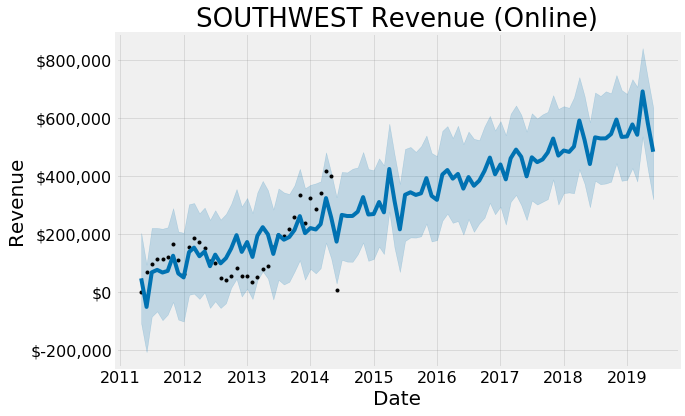

In [17]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
SW_model.plot(SW_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('SOUTHWEST Revenue (Online)');

<Figure size 2016x864 with 0 Axes>

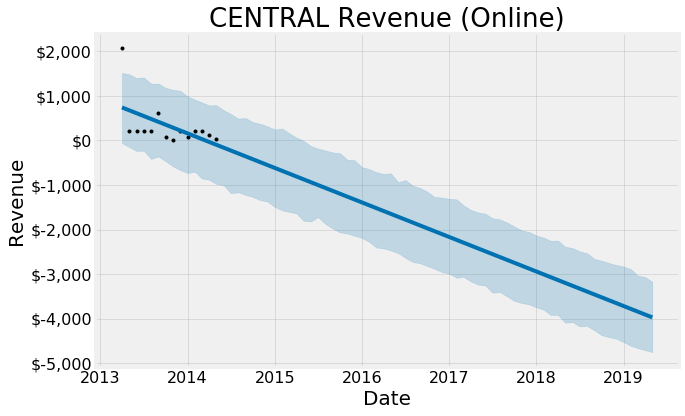

In [18]:
plt.figure(figsize=(28,12))
plt.rc('font', size=BIGGER_SIZE)
C_model.plot(C_forecast, xlabel = 'Date', ylabel = 'Revenue')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}")) #'${x:,.0f}
plt.title('CENTRAL Revenue (Online)');

# Compare Forecasts
We already have the forecasts for three years for these two Teritory into the future. We will now join them together to compare their future forecasts.

In [19]:
SE_names = ['SE_%s' % column for column in SE_forecast.columns]
SW_names = ['SW_%s' % column for column in SW_forecast.columns]
C_names = ['DE_%s' % column for column in C_forecast.columns]

merge_SE_forecast = SE_forecast.copy()
merge_SW_forecast = SW_forecast.copy()
merge_C_forecast = C_forecast.copy()

merge_SE_forecast.columns = SE_names
merge_SW_forecast.columns = SW_names
merge_C_forecast.columns = C_names


forecast = pd.merge(merge_SE_forecast, merge_SW_forecast, how = 'inner', left_on = 'SE_ds', right_on = 'SW_ds')
forecast = forecast.rename(columns={'SE_ds': 'Date'}).drop('SW_ds', axis=1)
forecast.head()

,Date,SE_trend,SE_yhat_lower,SE_yhat_upper,SE_trend_lower,SE_trend_upper,SE_additive_terms,SE_additive_terms_lower,SE_additive_terms_upper,SE_multiplicative_terms,...,SW_additive_terms,SW_additive_terms_lower,SW_additive_terms_upper,SW_yearly,SW_yearly_lower,SW_yearly_upper,SW_multiplicative_terms,SW_multiplicative_terms_lower,SW_multiplicative_terms_upper,SW_yhat
0,2012-07-01,446.380565,-1052.431680,2078.783884,446.380565,446.380565,0.0,0.0,0.0,0.0,...,-13536.719055,-13536.719055,-13536.719055,-13536.719055,-13536.719055,-13536.719055,0.0,0.0,0.0,129210.287145
1,2012-08-01,476.367254,-1053.993068,2088.161764,476.367254,476.367254,0.0,0.0,0.0,0.0,...,-49199.329876,-49199.329876,-49199.329876,-49199.329876,-49199.329876,-49199.329876,0.0,0.0,0.0,99230.054123
2,2012-09-01,506.353943,-1178.041079,2009.498072,506.353943,506.353943,0.0,0.0,0.0,0.0,...,-37051.581437,-37051.581437,-37051.581437,-37051.581437,-37051.581437,-37051.581437,0.0,0.0,0.0,117060.180363
3,2012-10-01,535.373319,-1045.970035,2022.334349,535.373319,535.373319,0.0,0.0,0.0,0.0,...,-9209.233824,-9209.233824,-9209.233824,-9209.233824,-9209.233824,-9209.233824,0.0,0.0,0.0,150401.603270
4,2012-11-01,565.360008,-961.539167,2111.604159,565.360008,565.360008,0.0,0.0,0.0,0.0,...,31253.630782,31253.630782,31253.630782,31253.630782,31253.630782,31253.630782,0.0,0.0,0.0,196546.845684


# Trend and Forecast Visualization

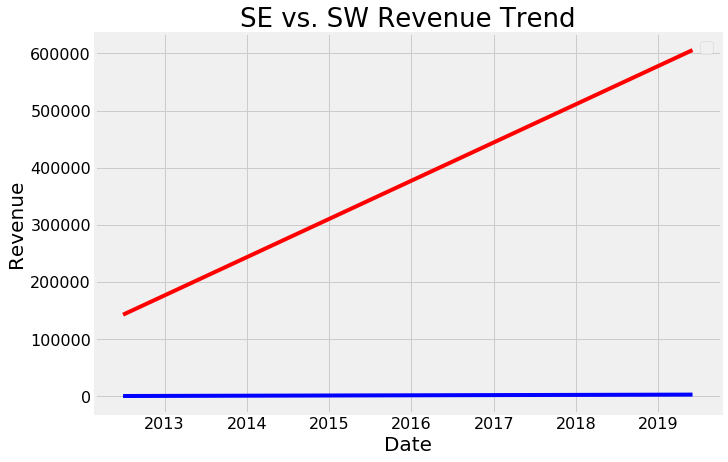

In [20]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['SE_trend'], 'b-')
plt.plot(forecast['Date'], forecast['SW_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.title('SE vs. SW Revenue Trend');

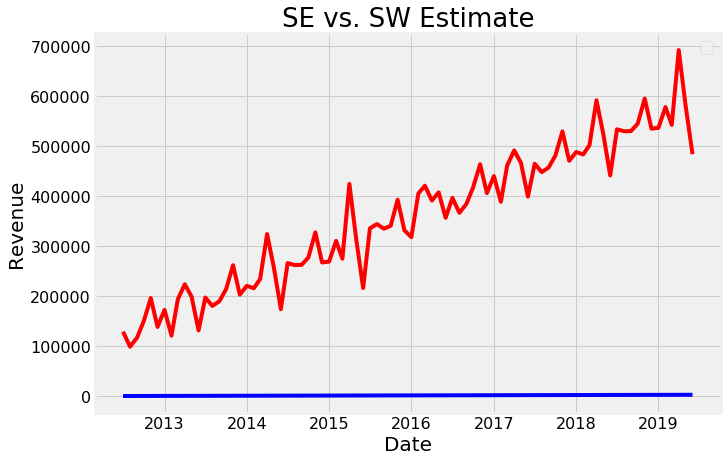

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['SE_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['SW_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Revenue')
plt.title('SE vs. SW Estimate');

# Trends and Patterns
Now, we can use the Prophet Models to inspect different trends of these two Teritory in the data.

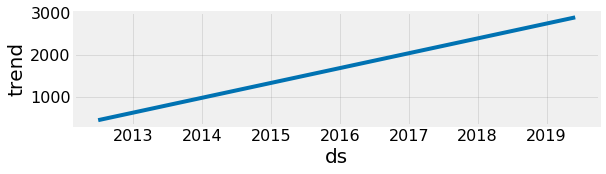

In [22]:
SE_model.plot_components(SE_forecast);

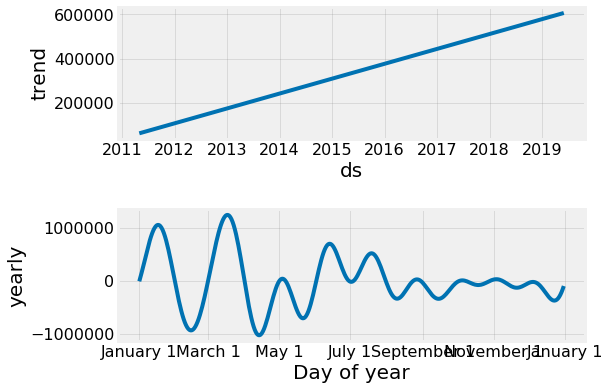

In [23]:
SW_model.plot_components(SW_forecast);

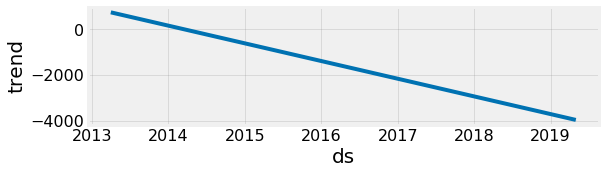

In [24]:
C_model.plot_components(C_forecast);

Good to see that the revenue for both Southwest and Central have been linearly increasing over time and will be keep growing, although Southeast’ growth seems downward.
The worst month for southeasr  is October, the worst month for Southwest is November. The best month for Southeast is September, and the best month for Southwest is December.
There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only just started.